<a href="https://colab.research.google.com/github/sohamthirty/Stock-Price-Prediction-with-Sentiment-Analysis/blob/main/Stock_Price_ProphetModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use Prophet Model to forecast close price

Reference links:

https://www.youtube.com/watch?v=03H2_ekdv2I

https://hareeshpb.medium.com/stock-prediction-using-prophet-python-525710e1ab0c

https://medium.com/mlearning-ai/multivariate-time-series-forecasting-using-fbprophet-66147f049e66

In [67]:
#!pip install pystan==2.19.1.1
#!pip install --upgrade holidays pystan

In [69]:
!pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
Failed to build fbprophet
ERROR: Could not build wheels for fbprophet, which is required to install pyproject.toml-based projects


In [70]:
!pip install prophet

In [71]:
!pip install pmdarima

In [72]:
import pandas as pd
import datetime as dt
import pandas_datareader.data as pdr
import os
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from prophet import Prophet
#from fbprophet import Prophet

### ANALYZE GOOGLE STOCK

In [73]:
data = pdr.get_data_yahoo(['GOOG'], start='2015-01-01', end='2019-12-31')
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268
2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796
2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800
2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082
2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641


In [74]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03
mean,45.649916,46.038350,45.260461,45.663827,45.663827,3.415121e+07
std,11.523511,11.629350,11.441770,11.539933,11.539933,1.697418e+07
min,24.664783,24.730902,24.311253,24.560070,24.560070,6.950000e+06
25%,36.463501,36.737000,36.116798,36.448002,36.448002,2.426200e+07
50%,46.477001,46.694000,46.172249,46.467999,46.467999,2.976400e+07
75%,55.632999,56.210999,55.183250,55.756500,55.756500,3.899600e+07
max,68.167503,68.250000,67.633499,68.058502,68.058502,2.232980e+08


<Axes: xlabel='Date'>

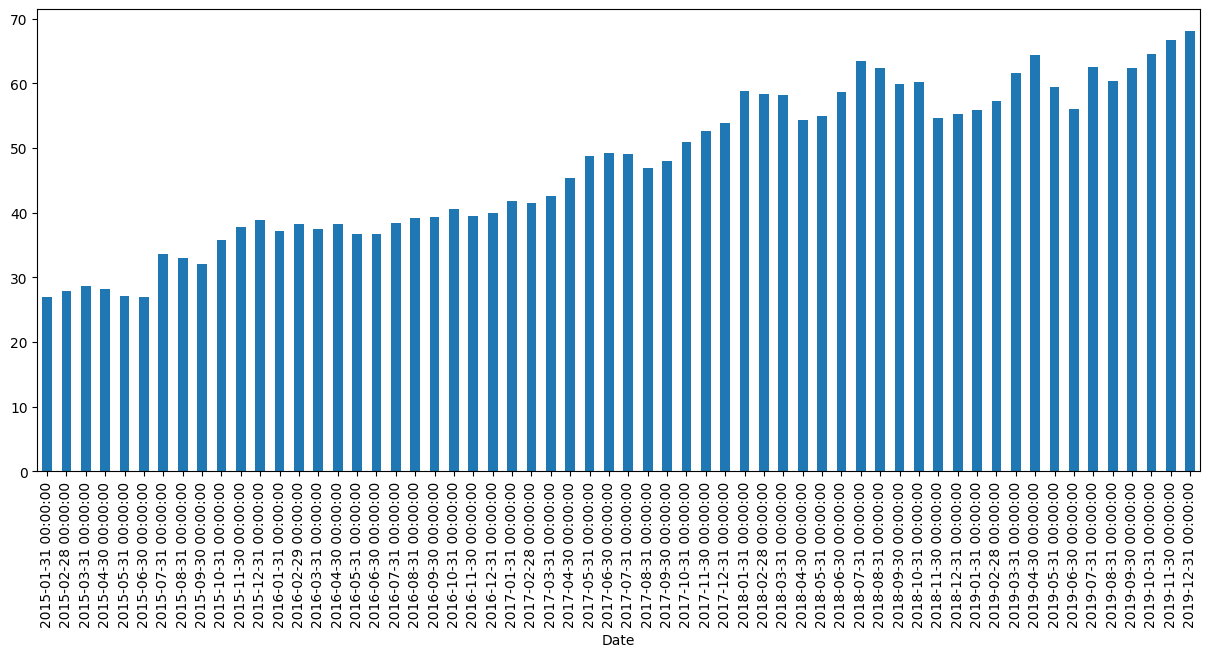

In [75]:
data.Close.resample(rule = 'M').max().plot(kind = 'bar', figsize = (15, 6))

Text(0, 0.5, 'Prices')

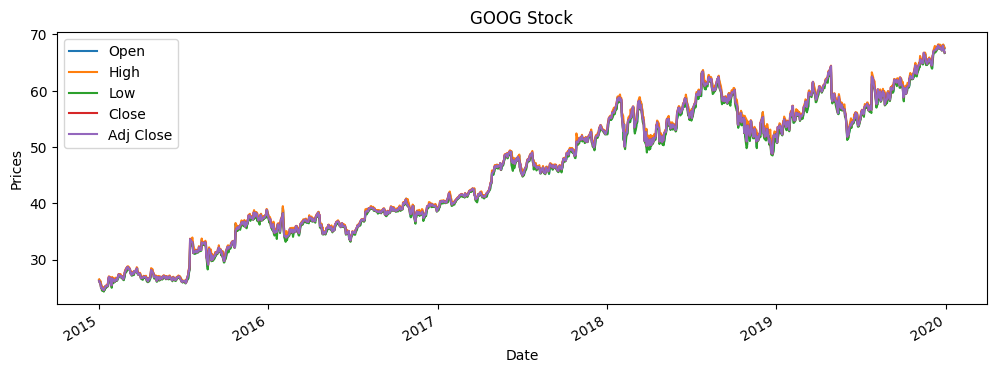

In [76]:
data.iloc[:, :-1].plot(figsize = (12, 4))
plt.title('GOOG Stock')
plt.ylabel('Prices')

<Axes: xlabel='Date'>

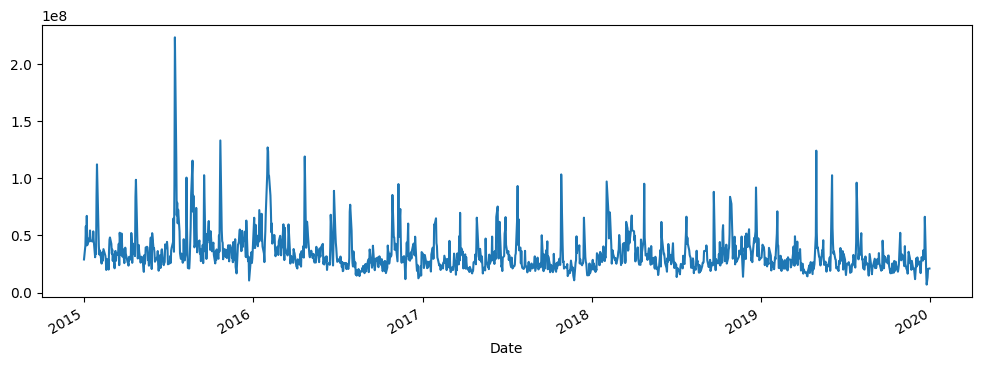

In [77]:
data.Volume.plot(figsize = (12, 4))

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

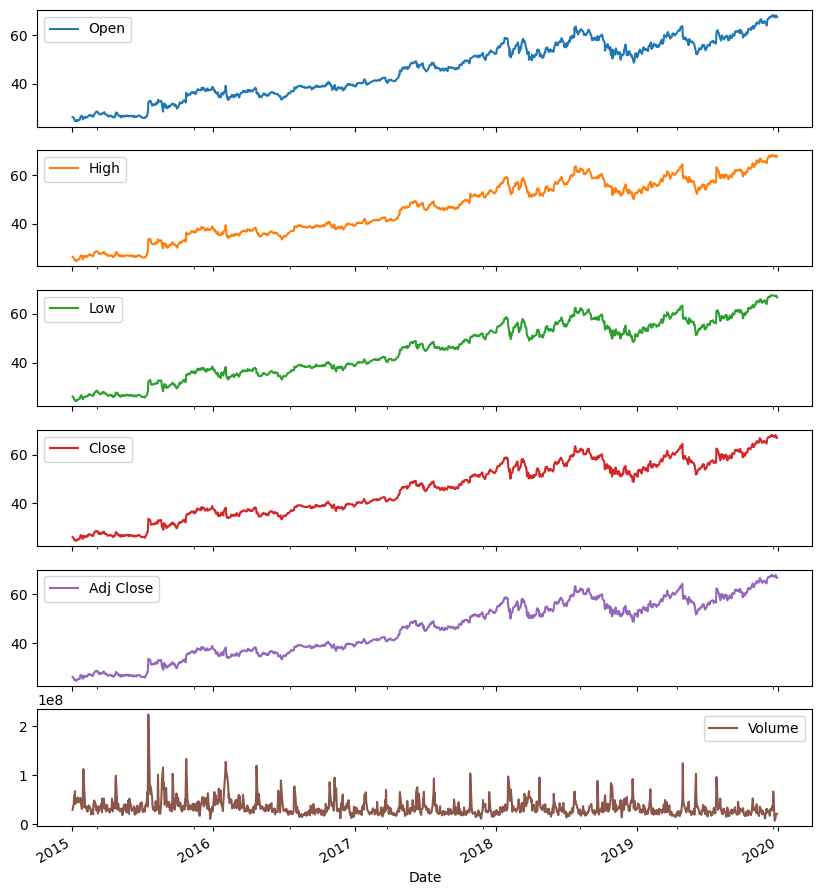

In [78]:
data.plot(subplots = True, figsize = (10, 12))

Lets look at the close value of the stock

<Axes: xlabel='Date'>

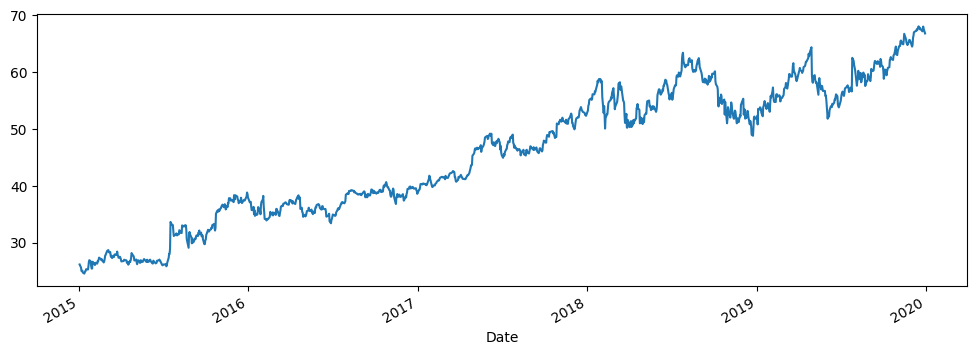

In [79]:
data.Close.plot(figsize = (12, 4))

Text(0.5, 1.0, 'Distribution of close prices over the days')

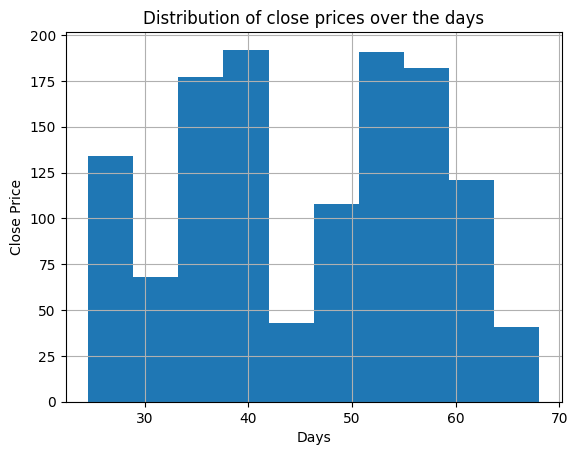

In [80]:
data.Close.hist()
plt.ylabel('Close Price')
plt.xlabel('Days')
plt.title('Distribution of close prices over the days')

In [81]:
data.Close.rolling(10).mean()

Date
2015-01-02          NaN
2015-01-05          NaN
2015-01-06          NaN
2015-01-07          NaN
2015-01-08          NaN
                ...    
2019-12-23    67.555800
2019-12-24    67.550300
2019-12-26    67.627200
2019-12-27    67.635300
2019-12-30    67.576849
Name: Close, Length: 1257, dtype: float64

## UNIVARIATE PROPHET MODEL - PREDICT NEXT YEAR

In [82]:
df_prophet = data
df_prophet = df_prophet.reset_index()
df_prophet

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268
1,2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796
2,2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800
3,2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082
4,2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641
...,...,...,...,...,...,...,...
1252,2019-12-23,67.793503,67.989998,67.325500,67.442001,67.442001,17662000
1253,2019-12-24,67.425003,67.513000,67.139000,67.178001,67.178001,6950000
1254,2019-12-26,67.308502,68.066353,67.223503,68.019997,68.019997,13350000
1255,2019-12-27,68.149498,68.226501,67.465500,67.594498,67.594498,20768000


In [83]:
df_prophet = df_prophet[['Date','Close']]
df_prophet.columns = ['ds','y']
df_prophet

,ds,y
0,2015-01-02,26.168653
1,2015-01-05,25.623152
2,2015-01-06,25.029282
3,2015-01-07,24.986401
4,2015-01-08,25.065184
...,...,...
1252,2019-12-23,67.442001
1253,2019-12-24,67.178001
1254,2019-12-26,68.019997
1255,2019-12-27,67.594498


In [84]:
m = Prophet(daily_seasonality=True)
m.fit(df_prophet) # Training
future = m.make_future_dataframe(periods=365) # predict next 365 days (2021)
forecast = m.predict(future) # Predictions
pd.options.display.max_columns = None
print(forecast.tail(2))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpflvfy_fx/tbjxfdnt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpflvfy_fx/4w44x_xn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67378', 'data', 'file=/tmp/tmpflvfy_fx/tbjxfdnt.json', 'init=/tmp/tmpflvfy_fx/4w44x_xn.json', 'output', 'file=/tmp/tmpflvfy_fx/prophet_modeltprwxilz/prophet_model-20231103063203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:32:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:32:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1620 2020-12-28  79.048540   69.758496   86.295025    70.757581    86.771121   
1621 2020-12-29  79.081937   69.744813   86.263450    70.759162    86.836218   

      additive_terms  additive_terms_lower  additive_terms_upper     daily  \
1620       -1.014553             -1.014553             -1.014553 -1.549227   
1621       -1.025074             -1.025074             -1.025074 -1.549227   

      daily_lower  daily_upper    weekly  weekly_lower  weekly_upper  \
1620    -1.549227    -1.549227 -0.123265     -0.123265     -0.123265   
1621    -1.549227    -1.549227 -0.104591     -0.104591     -0.104591   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
1620  0.657939      0.657939      0.657939                   0.0   
1621  0.628743      0.628743      0.628743                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper       yhat  
1620                        

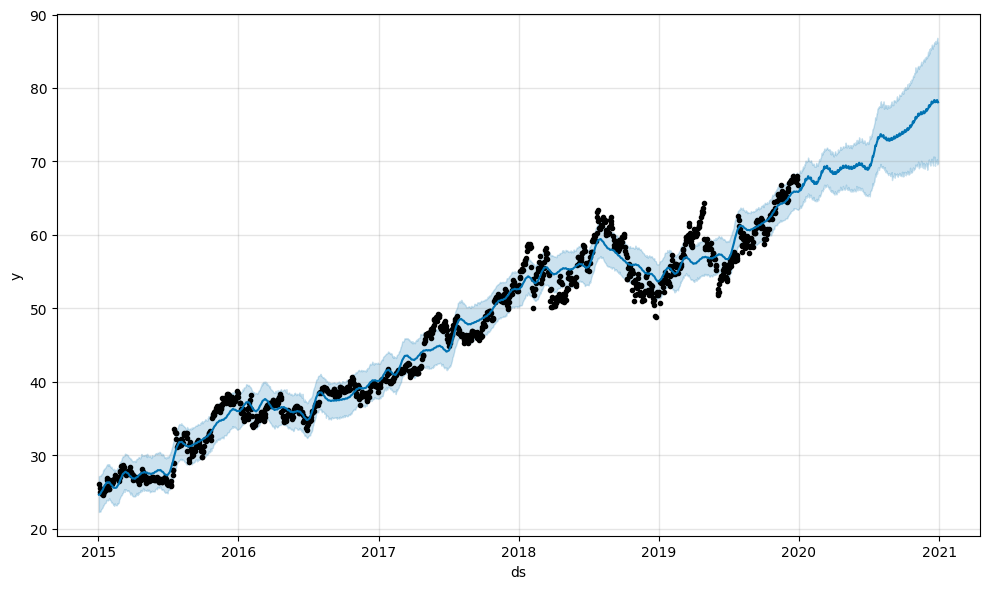

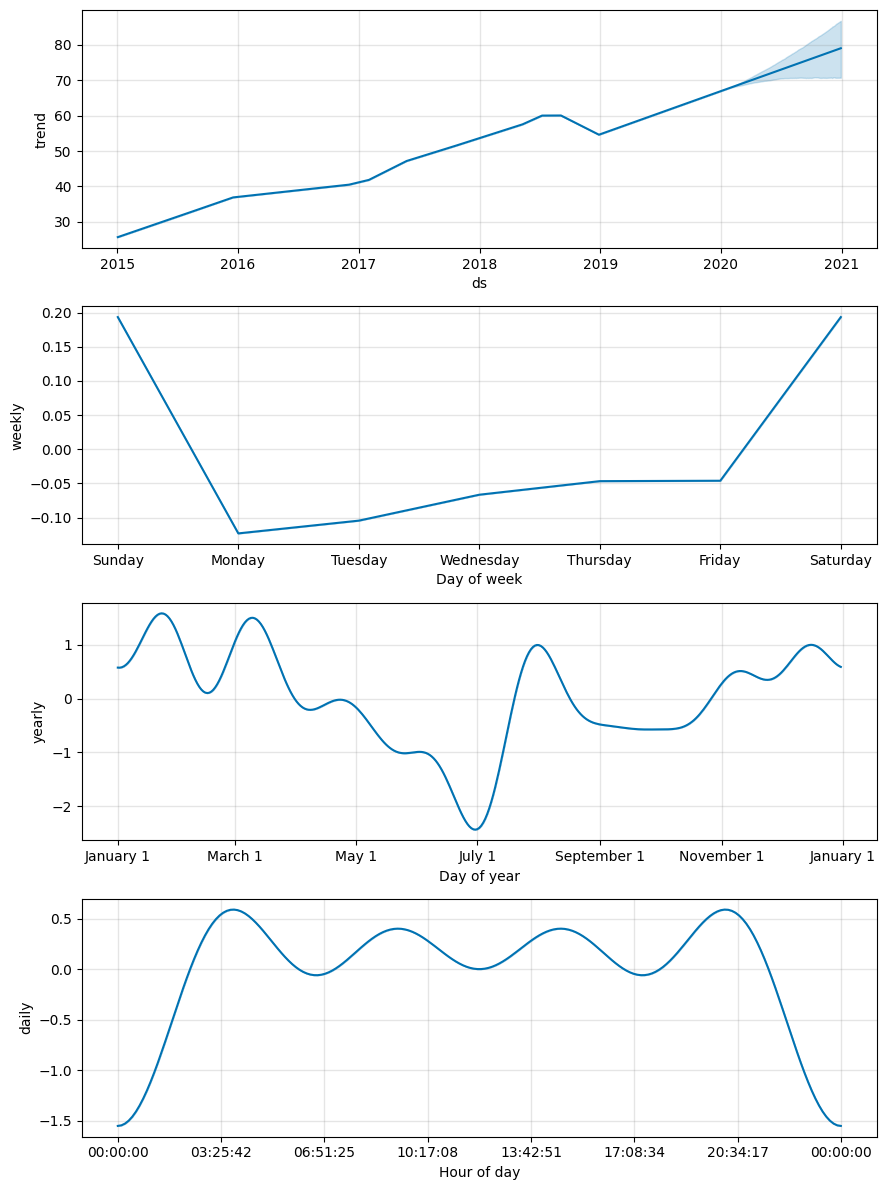

In [85]:
figure1 = m.plot(forecast)
figure2 = m.plot_components(forecast)

In [86]:
from prophet.plot import plot_plotly
plot_plotly(m,forecast)

## UNIVARIATE PROPHET  

## TRAIN : 2015 - 2018
## TEST : 2019

In [87]:
train1 = df_prophet[df_prophet['ds'] <= '2018-12-31']
test1 = df_prophet[df_prophet['ds'] >= '2019-01-01']

In [88]:
test1

,ds,y
1006,2019-01-02,52.292500
1007,2019-01-03,50.803001
1008,2019-01-04,53.535500
1009,2019-01-07,53.419498
1010,2019-01-08,53.813999
...,...,...
1252,2019-12-23,67.442001
1253,2019-12-24,67.178001
1254,2019-12-26,68.019997
1255,2019-12-27,67.594498


In [89]:
m1 = Prophet(daily_seasonality=True)
m1.fit(train1) # Training
future1 = m1.make_future_dataframe(periods=365) # predict next 365 days (2019)
forecast1 = m1.predict(future1) # Predictions
pd.options.display.max_columns = None
print(forecast1.tail(2))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpflvfy_fx/41p3ioft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpflvfy_fx/5ipr59fq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12734', 'data', 'file=/tmp/tmpflvfy_fx/41p3ioft.json', 'init=/tmp/tmpflvfy_fx/5ipr59fq.json', 'output', 'file=/tmp/tmpflvfy_fx/prophet_modelju7kos8a/prophet_model-20231103063211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:32:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:32:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1369 2019-12-30  51.808622   35.402495   66.909331    35.649603    66.949905   
1370 2019-12-31  51.804372   35.460751   66.728953    35.541395    67.004763   

      additive_terms  additive_terms_lower  additive_terms_upper    daily  \
1369       -0.156504             -0.156504             -0.156504  1.44772   
1370       -0.135427             -0.135427             -0.135427  1.44772   

      daily_lower  daily_upper    weekly  weekly_lower  weekly_upper  \
1369      1.44772      1.44772  0.018225      0.018225      0.018225   
1370      1.44772      1.44772  0.062870      0.062870      0.062870   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
1369 -1.622448     -1.622448     -1.622448                   0.0   
1370 -1.646017     -1.646017     -1.646017                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper       yhat  
1369                         0.

In [90]:
plot_plotly(m1,forecast1)

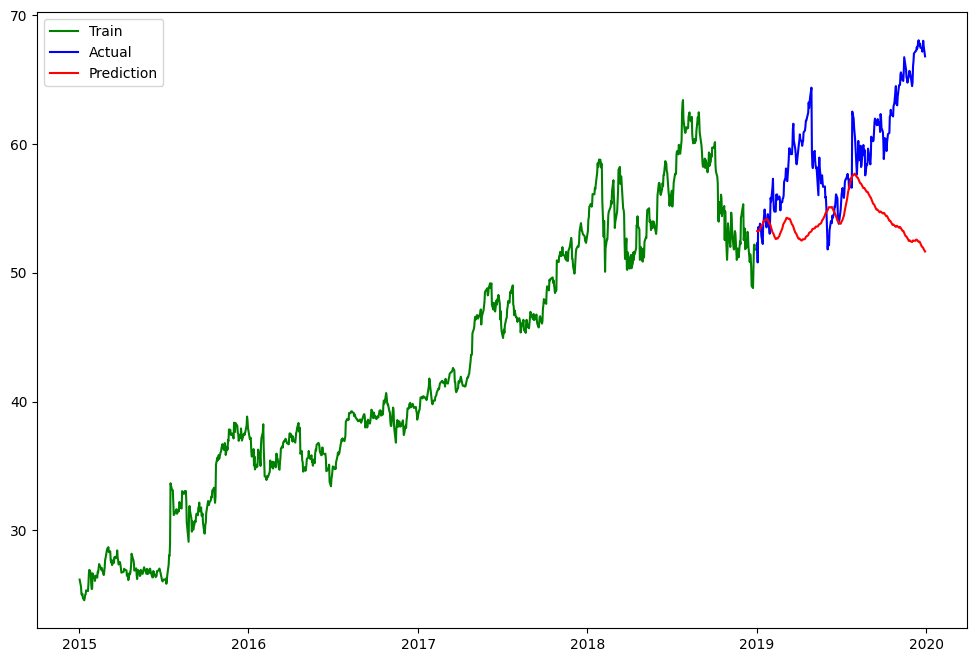

In [91]:
plt.figure(figsize=(12,8))

pred1 = forecast1[forecast1['ds'].isin(test1['ds'])]

plt.plot(pd.to_datetime(train1['ds']),train1['y'],'green',label = 'Train')
plt.plot(pd.to_datetime(test1['ds']),test1['y'],'blue',label = 'Actual')
plt.plot(pd.to_datetime(test1['ds']),pred1['yhat'],'red',label = 'Prediction')
plt.legend()

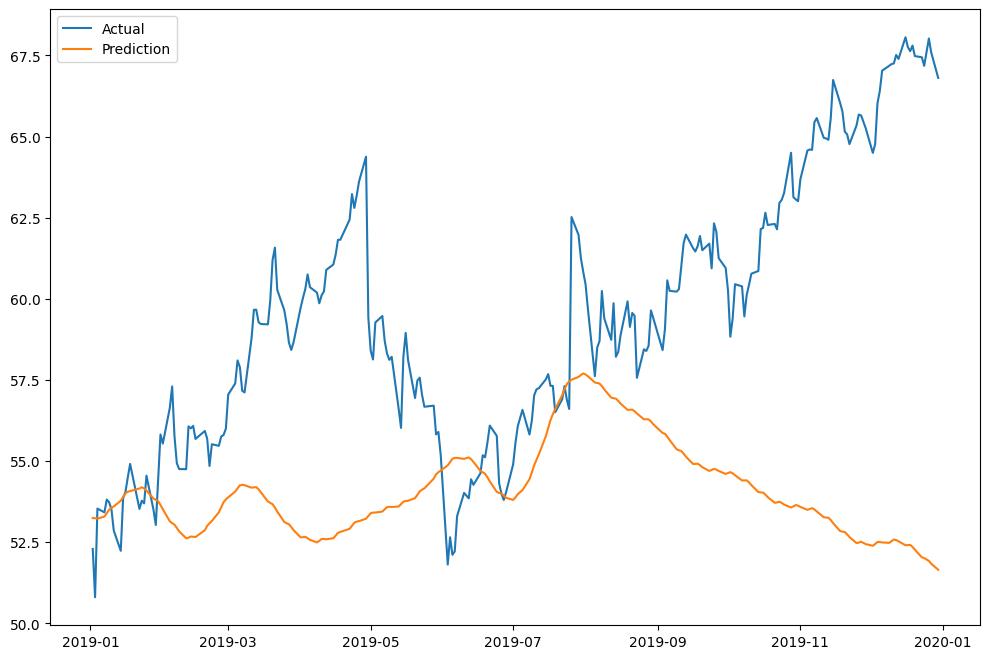

In [92]:
plt.figure(figsize=(12,8))

plt.plot(pd.to_datetime(test1['ds']),test1['y'],label = 'Actual')
plt.plot(pd.to_datetime(test1['ds']),pred1['yhat'],label = 'Prediction')
plt.legend()

In [93]:
results = {'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE'], 'Next 1 Year': [], 'Next 1 Month': [], 'Next 10 Days': []}

In [94]:
# report performance
mse = mean_squared_error(test1['y'], pred1['yhat'])
results['Next 1 Year'].append(mse)
print('MSE: '+str(mse))
mae = mean_absolute_error(test1['y'], pred1['yhat'])
results['Next 1 Year'].append(mae)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test1['y'], pred1['yhat']))
results['Next 1 Year'].append(rmse)
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred1['yhat'] - test1['y'])/np.abs(test1['y']))
results['Next 1 Year'].append(mape)
print('MAPE: '+str(mape))

MSE: 49.518637400496374
MAE: 5.48318977874956
RMSE: 7.036948017464416
MAPE: 0.08160099060204458


## TRAIN : 2015 - 2018
## TEST : 2019 FIRST 30 DAYS

In [95]:
train2 = df_prophet[df_prophet['ds'] <= '2018-12-31']
test2 = df_prophet[(df_prophet['ds'] >'2018-12-31') & (df_prophet['ds'] <='2019-1-30') ]


In [96]:
m2 = Prophet(daily_seasonality=True)
m2.fit(train2) # Training
future2 = m2.make_future_dataframe(periods=30) # predict next 30
forecast2 = m2.predict(future2) # Predictions
pd.options.display.max_columns = None
print(forecast2.tail(2))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpflvfy_fx/3xnsb0k1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpflvfy_fx/lekpr7u2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28720', 'data', 'file=/tmp/tmpflvfy_fx/3xnsb0k1.json', 'init=/tmp/tmpflvfy_fx/lekpr7u2.json', 'output', 'file=/tmp/tmpflvfy_fx/prophet_modelfqdir125/prophet_model-20231103063215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:32:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:32:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1034 2019-01-29  53.232426   51.950409   55.871243    53.083494    53.391792   
1035 2019-01-30  53.228176   51.699020   55.833219    53.056366    53.398153   

      additive_terms  additive_terms_lower  additive_terms_upper    daily  \
1034        0.574147              0.574147              0.574147  1.44772   
1035        0.533751              0.533751              0.533751  1.44772   

      daily_lower  daily_upper    weekly  weekly_lower  weekly_upper  \
1034      1.44772      1.44772  0.062870      0.062870      0.062870   
1035      1.44772      1.44772  0.111521      0.111521      0.111521   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
1034 -0.936443     -0.936443     -0.936443                   0.0   
1035 -1.025489     -1.025489     -1.025489                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper       yhat  
1034                         0.

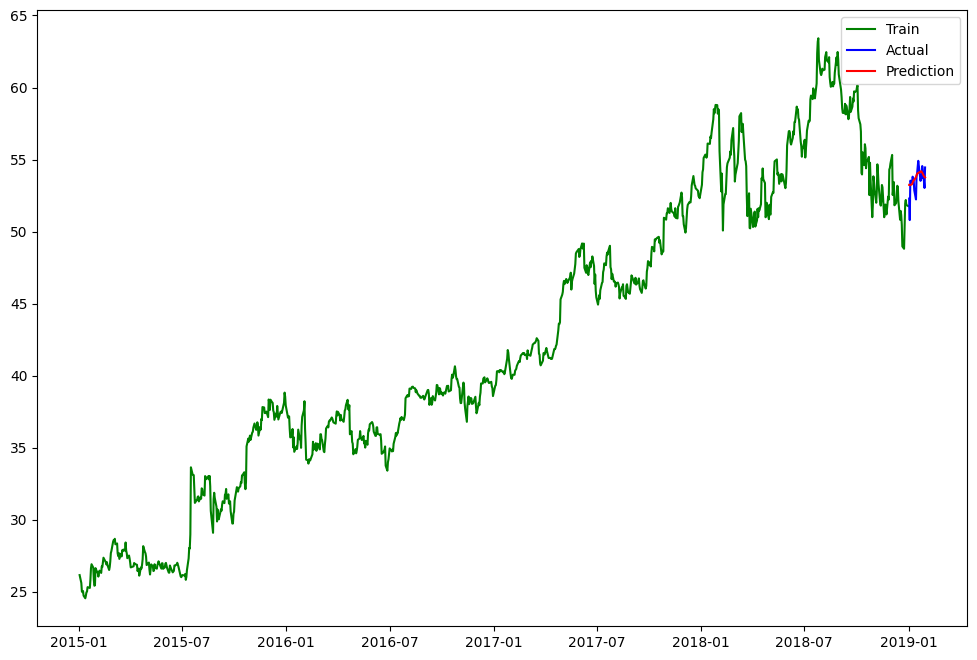

In [97]:
plt.figure(figsize=(12,8))

pred2 = forecast2[forecast2['ds'].isin(test2['ds'])]

plt.plot(pd.to_datetime(train2['ds']),train2['y'],'green',label = 'Train')
plt.plot(pd.to_datetime(test2['ds']),test2['y'],'blue',label = 'Actual')
plt.plot(pd.to_datetime(test2['ds']),pred2['yhat'],'red',label = 'Prediction')
plt.legend()

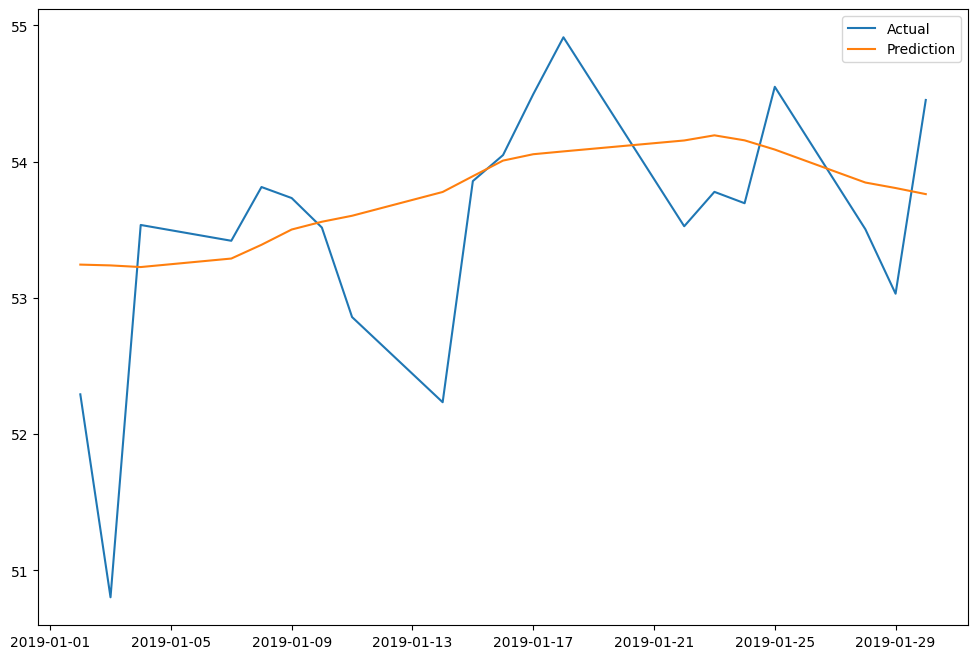

In [98]:
plt.figure(figsize=(12,8))

plt.plot(pd.to_datetime(test2['ds']),test2['y'],label = 'Actual')
plt.plot(pd.to_datetime(test2['ds']),pred2['yhat'],label = 'Prediction')
plt.legend()

In [99]:
# report performance
mse = mean_squared_error(test2['y'], pred2['yhat'])
results['Next 1 Month'].append(mse)
print('MSE: '+str(mse))
mae = mean_absolute_error(test2['y'], pred2['yhat'])
results['Next 1 Month'].append(mae)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test2['y'], pred2['yhat']))
results['Next 1 Month'].append(rmse)
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred2['yhat'] - test2['y'])/np.abs(test2['y']))
results['Next 1 Month'].append(mape)
print('MAPE: '+str(mape))

MSE: 0.6604524526796021
MAE: 0.5970887801259718
RMSE: 0.8126822581302007
MAPE: 0.010920585622540172


## TRAIN : 2015 - 2018
## TEST : 2019 FIRST 10 DAYS

In [100]:
train3 = df_prophet[df_prophet['ds'] <= '2018-12-31']
test3 = df_prophet[(df_prophet['ds'] >'2018-12-31') & (df_prophet['ds'] <='2019-1-10') ]


In [101]:
m3 = Prophet(daily_seasonality=True)
m3.fit(train3) # Training
future3 = m3.make_future_dataframe(periods=10) # predict next 10
forecast3 = m3.predict(future3) # Predictions
pd.options.display.max_columns = None
print(forecast3.tail(2))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpflvfy_fx/zvwxrv6w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpflvfy_fx/pgi9flte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28686', 'data', 'file=/tmp/tmpflvfy_fx/zvwxrv6w.json', 'init=/tmp/tmpflvfy_fx/pgi9flte.json', 'output', 'file=/tmp/tmpflvfy_fx/prophet_modelqguky73r/prophet_model-20231103063220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:32:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:32:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1014 2019-01-09  53.317429   51.501973   55.506401    53.317429    53.317429   
1015 2019-01-10  53.313179   51.684468   55.594594    53.313179    53.313179   

      additive_terms  additive_terms_lower  additive_terms_upper    daily  \
1014        0.184707              0.184707              0.184707  1.44772   
1015        0.245989              0.245989              0.245989  1.44772   

      daily_lower  daily_upper    weekly  weekly_lower  weekly_upper  \
1014      1.44772      1.44772  0.111521      0.111521      0.111521   
1015      1.44772      1.44772  0.099345      0.099345      0.099345   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
1014 -1.374534     -1.374534     -1.374534                   0.0   
1015 -1.301076     -1.301076     -1.301076                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper       yhat  
1014                         0.

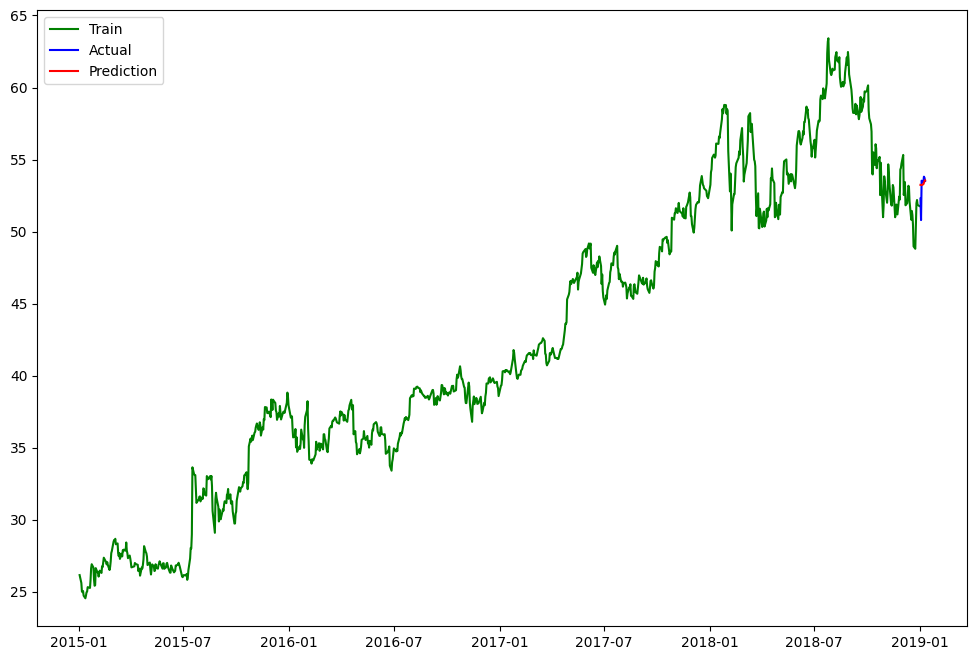

In [102]:
plt.figure(figsize=(12,8))

pred3 = forecast3[forecast3['ds'].isin(test3['ds'])]

plt.plot(pd.to_datetime(train3['ds']),train3['y'],'green',label = 'Train')
plt.plot(pd.to_datetime(test3['ds']),test3['y'],'blue',label = 'Actual')
plt.plot(pd.to_datetime(test3['ds']),pred3['yhat'],'red',label = 'Prediction')
plt.legend()

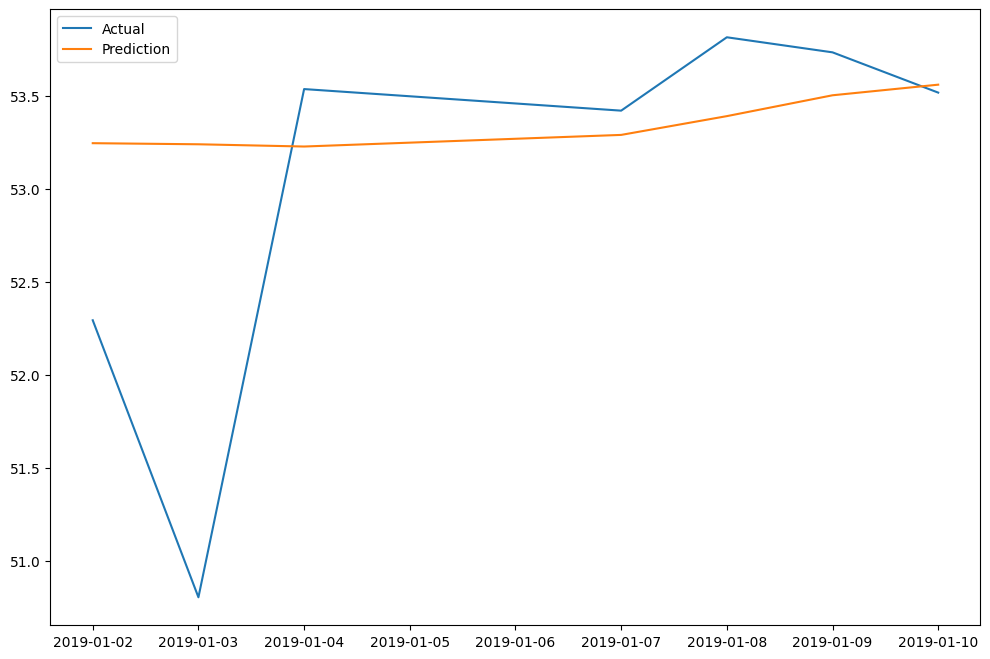

In [103]:
plt.figure(figsize=(12,8))

plt.plot(pd.to_datetime(test3['ds']),test3['y'],label = 'Actual')
plt.plot(pd.to_datetime(test3['ds']),pred3['yhat'],label = 'Prediction')
plt.legend()

In [104]:
# report performance
mse = mean_squared_error(test3['y'], pred3['yhat'])
results['Next 10 Days'].append(mse)
print('MSE: '+str(mse))
mae = mean_absolute_error(test3['y'], pred3['yhat'])
results['Next 10 Days'].append(mae)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test3['y'], pred3['yhat']))
results['Next 10 Days'].append(rmse)
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred3['yhat'] - test3['y'])/np.abs(test3['y']))
results['Next 10 Days'].append(mape)
print('MAPE: '+str(mape))

MSE: 1.0266043028252088
MAE: 0.6463662625866574
RMSE: 1.013214835474298
MAPE: 0.015365996834996861


In [105]:
df_results = pd.DataFrame(results)
df_results.set_index('Metric',  inplace=True)
df_results = df_results.apply(lambda x: round(x, 2))
df_results

,Next 1 Year,Next 1 Month,Next 10 Days
Metric,,,
MSE,49.52,0.66,1.03
MAE,5.48,0.60,0.65
RMSE,7.04,0.81,1.01
MAPE,0.08,0.01,0.02


## MULTIVARIATE PROPHET
